# My Image Classifier

I will be applying knowledge i have learnt from the course work to create an image classifer from scartch as my final submission.
We'll be using the dataset of 102 flower categories provided from the workspace


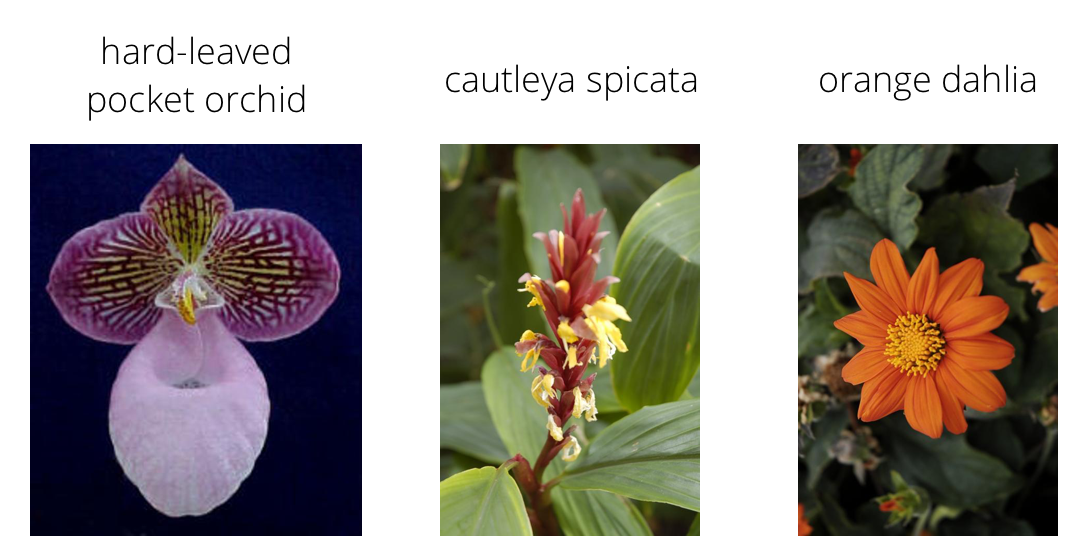 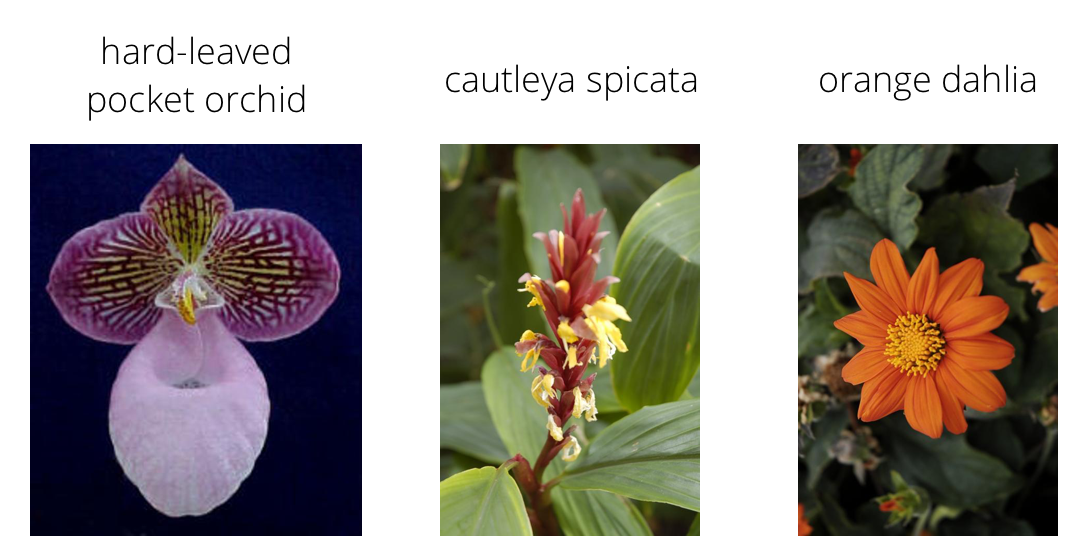 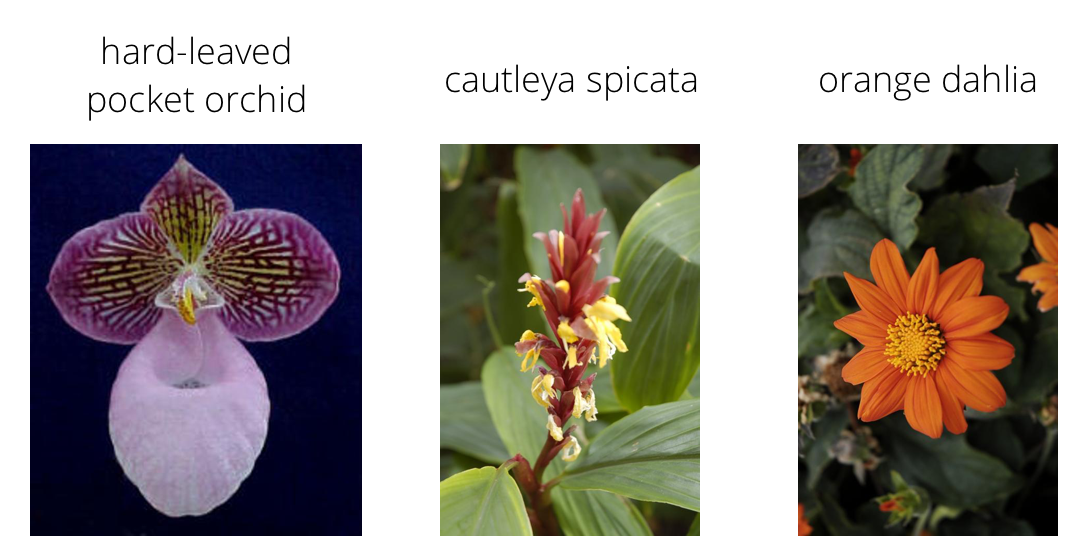

The project will be broken down into multiple steps:

1. Load and preprocess the image dataset
2. Train the image classifier on the dataset
3. Use the trained classifier to predict image content

In [1]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch # ML framework that provides tools for building and training neural networks
import torch.nn as nn # building blocks for creating neural network models
import torch.optim as optim # provides optimization algorithms like SGD (Stochastic Gradient Descent)
import torchvision # provides popular datasets, model architectures, and image transformations
import torchvision.transforms as transforms # common image transformations and data preprocessing operations
from torchvision.datasets import ImageFolder # loads images with folder structure
from torch.utils.data import DataLoader # create batches of data for training and evaluation
import scipy.io # scipy.io is a module for working with MATLAB files
from PIL import Image # Python Imaging Library (PIL) for working with images
import os # os provides functions for interacting with the operating system, like file operations
import urllib.request # urllib.request is used for downloading data from URLs
import tarfile # tarfile is a module for working with tar archives
from torchvision.datasets.utils import download_url # download_url is a function from torchvision for downloading files from URLs


# 1. Load and Process the image dataset

In [2]:
# Define URLs
data_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
labels_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'

# Download and extract data
data_filename = '102flowers.tgz'
download_url(data_url, root='./', filename=data_filename, md5=None)

with tarfile.open(data_filename, 'r:gz') as tar:
    tar.extractall(path='./')
    
# Now the data is extracted in the current directory, so we can use it with ImageFolder
data_dir = './jpg'

# Load class labels from the .mat file
labels_file = 'imagelabels.mat'
urllib.request.urlretrieve(labels_url, labels_file)
labels_mat = scipy.io.loadmat(labels_file)
class_labels = labels_mat['labels'][0] - 1 

  0%|          | 1277952/344862509 [03:10<33:39:27, 2835.63it/s]

In [ ]:
#Let have a look at the data loaded
# Visualize 
def imshow_batch(images, class_names=None):
    plt.figure(figsize=(12, 8))
    grid = torchvision.utils.make_grid(images, nrow=4)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    if class_names:
        plt.title(' / '.join(class_names))
    plt.show()


# 2. creating a classifier and Training image 

In [ ]:
#Prep the data for training
# Define data transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the flower dataset using ImageFolder
flower_dataset = ImageFolder(root=data_dir, transform=data_transform)
flower_loader = DataLoader(flower_dataset, batch_size=4, shuffle=True, num_workers=4)

# Get a batch of data for visualization
dataiter = iter(flower_loader)
images, labels = dataiter.next()

# Visualize the loaded data
imshow_batch(images, [flower_dataset.classes[label] for label in labels])




In [ ]:
#Simple classifier
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc(x)
        return x

# Instantiate the model
input_size = 224 * 224 * 3  # Input size based on image dimensions
num_classes = len(np.unique(class_labels))
model = SimpleClassifier(input_size, num_classes)


In [ ]:
# Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in flower_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Visualize a batch of data during training
    imshow_batch(inputs, [flower_dataset.classes[label] for label in labels])
    
print('Finished Training')


# 3. Testing/Prediction and visulizing

In [ ]:
# Get a batch of data for prediction
dataiter = iter(flower_loader)
images, labels = dataiter.next()

# Predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Visualize predictions
def visualize_predictions(images, labels, predicted, class_names):
    imshow_batch(images, ['GT: {} / Pred: {}'.format(class_names[labels[i]], class_names[predicted[i]]) for i in range(len(images))])

# Visualize predictions
visualize_predictions(images, labels, predicted, flower_dataset.classes)


# Advancing my classifier

In [ ]:
class AdvancedClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AdvancedClassifier, self).__init__()
        
        # Define layers with non-linear activations
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 56 * 56, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Instantiate the advanced model
model_advanced = AdvancedClassifier(input_size, num_classes)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_advanced.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in flower_loader:
        optimizer.zero_grad()
        outputs = model_advanced(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Visualize a batch of data during training
    imshow_batch(inputs, [flower_dataset.classes[label] for label in labels])
    
print('Finished Training')


###  Predicting using advanced classifier

In [ ]:
# Get a batch of data for prediction
dataiter = iter(flower_loader)
images, labels = dataiter.next()

# Predictions using the advanced model
outputs_advanced = model_advanced(images)
_, predicted_advanced = torch.max(outputs_advanced, 1)

# Predictions using the simple model
outputs_simple = model(images)
_, predicted_simple = torch.max(outputs_simple, 1)

# Visualize predictions and compare metrics
def compare_predictions(images, labels, predicted_simple, predicted_advanced, class_names):
    plt.figure(figsize=(12, 8))
    grid = torchvision.utils.make_grid(images, nrow=4)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    for i in range(len(images)):
        title = 'GT: {} / Simple: {} / Advanced: {}'.format(
            class_names[labels[i]],
            class_names[predicted_simple[i]],
            class_names[predicted_advanced[i]]
        )
        plt.title(title)
    plt.show()

# Visualize and compare predictions
compare_predictions(images, labels, predicted_simple, predicted_advanced, flower_dataset.classes)
